In [9]:
from somefunctions import *
from f1_score import *

# Configuration parameters
Easier if we put them all togheter

In [2]:
# Model parameters
pool_size = (2, 2)
train_shape = 400 #size of the training images
patch_size = 16
input_size = 64
pad_size = int(input_size/2 - patch_size/2)


# Training parameters
reg = 1e-5  #regularization term
learning_rate = 0.001
nb_epoch = 40 #very small, only preliminary tests
batch_size = 256
steps_per_epoch = 125 #the number of training samples is huge, arbitrary value


# Data augmentation parameters
FLIP_FLAG = True # add random flips to the patches
ROTATION_FLAG = True # add random rotation to the patches
BRIGHT_CONTRAST_FLAG = True # modify randomly the brightness and the constrast


#Other stuff
NameWeights = 'LeoWeights_1012'
SubmissionName = 'LeoSubmission_1012.csv'

# Function to generate the minibatch + data augmentation
This function will be called during the training. <br>

In [3]:
def data_augmentation(X):
    '''Data augmentation on X, element of size (input_size * input_size * 3)'''
    #flip
    if FLIP_FLAG:
        flip_decision = np.random.choice(3)
        if flip_decision == 1:
            X = np.flipud(X)
        if flip_decision == 2: 
            X = np.fliplr(X)
    
    #rotate
    if ROTATION_FLAG:
        number_of_rotations = np.random.choice(3)
        X = np.rot90(X, number_of_rotations)
    
    #contrast and brightness
    if BRIGHT_CONTRAST_FLAG:
        brightness = np.random.rand()*0.3 - 0.15
        contrast = np.random.rand()*0.25 - 0.125
        X = np.clip( X * (contrast/0.5+1) - contrast + brightness, 0, 1)
        
    return X

def generate_minibatch(X,Y):
    """
    Generate a minibatch
    """
    while 1:
        # Generate one minibatch
        X_batch = np.empty((batch_size, input_size, input_size, 3))
        Y_batch = np.empty(batch_size)
        low=input_size//2
        high = (train_shape + 2*pad_size - input_size//2)
        for i in range(batch_size):
            # Select a random image
            idx = np.random.choice(X.shape[0])
            
            x_coord = np.random.randint(low=low, high = high ) 
            y_coord = np.random.randint(low=low, high = high )
      
            X_temp = X[idx,x_coord - input_size//2:x_coord + input_size//2,
                           y_coord - input_size//2:y_coord + input_size//2]
            X_batch[i] = data_augmentation(X_temp)
            
            gt_temp = Y[idx,x_coord - patch_size//2:x_coord + patch_size//2,
                            y_coord - patch_size//2:y_coord + patch_size//2]            
            Y_batch[i] = patch_to_label(gt_temp)
            
        yield X_batch, Y_batch

# Train
Generate the model and train the dataset

In [11]:
def create_model():
    '''Create a sequential model'''        
    model = Sequential()
    
    model.add(Convolution2D(32, (5,5), 
                            input_shape = ( input_size, input_size, 3),
                            padding = 'SAME', activation = 'relu'))
    
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Convolution2D(64, (5,5), 
                            input_shape = ( input_size, input_size, 3),
                            padding = 'SAME', activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Dropout(0.5))
    
    model.add(Convolution2D(128, (3,3),
                            padding = 'SAME', activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Convolution2D(256, (3,3),
                            padding = 'SAME', activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(512, activation = 'relu', kernel_regularizer = l2(reg)))
    model.add(Dropout(0.5))         
    model.add(Dense(256, activation = 'relu', kernel_regularizer = l2(reg)))
    model.add(Dropout(0.5))       
    model.add(Dense(units = 1, activation = 'sigmoid'))

    #Optimizer          
    opt = Adam(lr=learning_rate) # Adam optimizer with default initial learning rate
 

    # This callback reduces the learning rate when the training accuracy does not improve any more
    lr_callback = ReduceLROnPlateau(monitor='acc', factor=0.5, patience=5,
                                    verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    
    # Stops the training process upon convergence
    stop_callback = EarlyStopping(monitor='acc', min_delta=0.0001, patience=10, verbose=1, mode='auto')
    
    model.compile(loss=binary_crossentropy,
                  optimizer=opt,
                  metrics=['acc', f1_score])
    
    return model, stop_callback, lr_callback

    

def train(X, Y):    
    '''
    Generate an instance of the model an train the model on X, Y
    '''
    print('Training set shape: ', X.shape) 
    print(f'Batch_size: {batch_size} \nSteps per epoch: {steps_per_epoch} \n')
    
    
    model, stop_callback, lr_callback = create_model()
    
    np.random.seed(20122018) # Reproducibility + remember the deadline is the 20.12.2018
    
    try:
        model.fit_generator(generate_minibatch(X,Y),
                            steps_per_epoch=steps_per_epoch,
                            nb_epoch=nb_epoch,
                            verbose=1,
                            callbacks=[lr_callback, stop_callback])
    except KeyboardInterrupt:
        print('\n\nKeyboard interruption!\n\n')
        pass
    

    model.save_weights(NameWeights)
    
    print(f'Training completed, weights saved in: {NameWeights}')
    
    return model

# Load images

In [12]:
# Load a set of image
root_dir = "../Data/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = len(files) 
print("Loading " + str(n) + " images")
imgs_original = [load_image(image_dir + files[i]) for i in range(n)]
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
gt_imgs_not_padded = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

Loading 100 images
satImage_052.png
Loading 100 images
satImage_052.png


# Preprocessing on the whole images

Simply padding

In [13]:
imgs = padding_imgs(np.array(imgs),pad_size)
gt_imgs = padding_GT(np.array(gt_imgs),pad_size)
print(imgs.shape)
print(gt_imgs.shape)

(100, 448, 448, 3)
(100, 448, 448)


# Training

# split in validation + train

(VERY BASIC!) In this way we can check directly what happens in the validation set

In [14]:
# N = imgs.shape[0]
# ratio = 0.8
# N_train = int(N*ratio)
# N_valid = int(N - N*ratio)
# X_train = imgs[:N_train]
# X_valid = imgs[N-N_valid:]
# Y_train = gt_imgs[:N_train]
# print(X_train.shape)
# print(X_valid.shape)
# print(X_train.shape[0] + X_valid.shape[0])
# model = train(X_train,Y_train)

# Since it is very slow, our validation is directly crowdAI, skip the validation part....

In [15]:
X_train = imgs
Y_train = gt_imgs
model = train(X_train,Y_train)

Training set shape:  (100, 448, 448, 3)
Batch_size: 256 
Steps per epoch: 125 



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=125, verbose=1, callbacks=[<keras.ca..., epochs=40)`


Epoch 1/40
125/125 [==============================] - 669s 5s/step - loss: 0.5828 - acc: 0.7395 - f1_score: 0.0035
Epoch 2/40
125/125 [==============================] - 689s 6s/step - loss: 0.5374 - acc: 0.7429 - f1_score: 0.0000e+00
Epoch 3/40
125/125 [==============================] - 695s 6s/step - loss: 0.4844 - acc: 0.7596 - f1_score: 0.1835
Epoch 4/40
125/125 [==============================] - 696s 6s/step - loss: 0.4112 - acc: 0.8089 - f1_score: 0.5485
Epoch 5/40
125/125 [==============================] - 693s 6s/step - loss: 0.3669 - acc: 0.8377 - f1_score: 0.6491
Epoch 6/40
125/125 [==============================] - 706s 6s/step - loss: 0.3238 - acc: 0.8602 - f1_score: 0.7044
Epoch 7/40
125/125 [==============================] - 693s 6s/step - loss: 0.3112 - acc: 0.8651 - f1_score: 0.7161
Epoch 8/40
125/125 [==============================] - 692s 6s/step - loss: 0.2833 - acc: 0.8782 - f1_score: 0.7458
Epoch 9/40
125/125 [==============================] - 692s 6s/step - loss: 0

# if we want to go on with the training ...

In [16]:
# X_train = imgs
# Y_train = gt_imgs
# model, lr_callback, stop_callback = create_model()
# model.load_weights('NicolaWeights0612')

# np.random.seed(3) # Reproducibility + remember the deadline is the 20.12.2018
    
# try:
#     model.fit_generator(generate_minibatch(X_train,Y_train),
#                             steps_per_epoch=steps_per_epoch,
#                             nb_epoch=3,
#                             verbose=1,
#                             callbacks=[lr_callback, stop_callback])
# except KeyboardInterrupt:
#     print('\n\nKeyboard interruption!\n\n')
#     pass
# model.save_weights('NicolaWeights2')

# Check if on the train set we have good results

In [17]:
IDX = 1
X = imgs_to_windows(imgs,400,patch_size,input_size)
patches_idx = X[625*IDX:625*(IDX+1)]

print(X.shape)
print(patches_idx.shape)

(62500, 64, 64, 3)
(625, 64, 64, 3)


In [18]:
Z_idx = model.predict(patches_idx)
labels_idx = (Z_idx > 0.5) *1 
print(Z_idx[:3])    

[[0.00214587]
 [0.00025843]
 [0.00901739]]


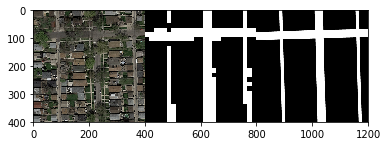

In [19]:
predicted_image = label_to_img(400,400,16,16,labels_idx)
temp = concatenate_images(imgs_original[IDX],predicted_image)
plt.imshow(concatenate_images(temp, gt_imgs_not_padded[IDX]))

# Check what happens on the validation set

In [ ]:
# # Recover the weights without training everything again
# model,_,_ = create_model()
# model.load_weights(NameWeights)

In [ ]:
# #create the input for the model
# val_inputs = imgs_to_windows(X_valid,400,patch_size,input_size)
# print(val_inputs.shape)

In [ ]:
# #get the true value of the labels
# Y_valid = gt_imgs_not_padded[N-N_valid:]
# val_gt_patches = [img_crop(Y_valid[i], patch_size, patch_size) for i in range(N_valid)]
# val_gt_patches =  np.asarray([val_gt_patches[i][j] for i in range(len(val_gt_patches)) for j in range(len(val_gt_patches[i]))])
# val_true_labels = np.asarray([value_to_class(np.mean(val_gt_patches[i])) for i in range(len(val_gt_patches))])
# print(val_true_labels.shape)

In [ ]:
# #predict
# val_prediction = model.predict(val_inputs)
# print(val_prediction[0:3])

In [ ]:
# # compute the metrics
# from sklearn.metrics import f1_score
# val_predicted_labels = ( (val_prediction < 0.5) * 1 ).flatten()
# val_accuracy = np.sum(np.abs(val_predicted_labels - val_true_labels))/val_true_labels.shape[0]
# print('Accuracy on validation set is: ', val_accuracy)
# print('F1 score on validation set is:', f1_score(val_true_labels,val_predicted_labels))

# predict on test

In [20]:
#load images and pad them
test_images = np.asarray(pick_test_images())

test_images = padding_imgs(np.array(test_images),pad_size)

test_images_not_padded = np.asarray(pick_test_images())

In [21]:
#prepare the input for the prediction
test_inputs = imgs_to_windows(test_images,608,patch_size,input_size)
print(test_inputs.shape)

(72200, 64, 64, 3)


In [22]:
#recover the model
model, _,_ = create_model()
model.load_weights(NameWeights)

In [23]:
#predict
test_prediction = model.predict(test_inputs)
print(test_prediction[0:3])

[[0.21365225]
 [0.9753796 ]
 [0.8674117 ]]


In [24]:
test_predicted_labels = ( (test_prediction > 0.5) * 1 ).flatten()
test_labels = test_predicted_labels.reshape(50,-1)
print('Every row contains the labels of one image')
print(test_labels.shape)

Every row contains the labels of one image
(50, 1444)


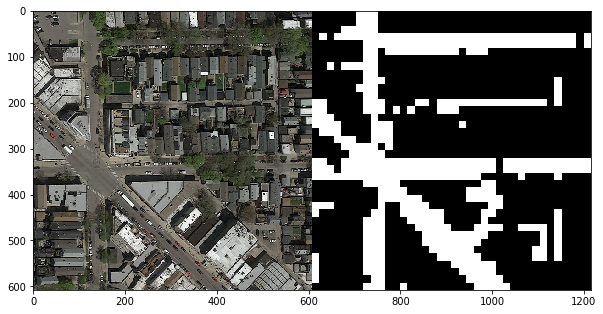

In [25]:
#check the prediction on the image IDX
IDX = 18
im = label_to_img(608, 608, 16, 16, test_labels[IDX])
plt.figure(figsize=[10,20])
plt.imshow(concatenate_images(test_images_not_padded[IDX], im))

In [26]:
MY_masks_to_submission(SubmissionName, test_labels)